<a href="https://colab.research.google.com/github/rutgerhofste/aqueduct30_plot/blob/master/scripts/Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
Plot Aqueduct monthly water stress 


"""

SCRIPT_NAME = "Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01"
OUTPUT_VERSION = 4

GCS_INPUT_PATH_DATA = 'gs://aqueduct30_v01/Y2019M07D12_Aqueduct30_V01'
GCS_INPUT_PATH_GEOM = "gs://aqueduct30_v01/Y2019M07D24_RH_Reproject_Simplified_Geometries_V01/output_V01/miller"


TESTING = 0

output_path = "{}/output_V{:02.0f}".format(SCRIPT_NAME,OUTPUT_VERSION)


GCS_OUTPUT_PATH = "gs://aqueduct30_v01/{}".format(output_path)

In [2]:
!pip install geopandas

In [0]:
import geopandas as gpd
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import calendar


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:

#https://epsg.io/54030
robinson = "+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

#https://epsg.io/54003
miller = "+proj=mill +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +R_A +datum=WGS84 +units=m +no_defs"

In [6]:
!mkdir -p {output_path}
!mkdir ./input_data

mkdir: cannot create directory ‘./input_data’: File exists


In [0]:
!gsutil -m -q cp -r {GCS_INPUT_PATH_DATA} ./input_data 
!gsutil -m -q cp -r {GCS_INPUT_PATH_GEOM} ./input_data 

In [0]:
def get_boundaries(perspective="intl"):
  """
  Get bounds and country files based on WRI's bounds github repo
  https://github.com/wri/wri-bounds
  
  Args:
    perspective(string): perspecive, options intl ch in for international
      china and india respectively. default: intl
  Returns:
    all_countries(geodataframe): GeoDataFrae with all countries.
    non_disputed(geodataframe): GeoDataFrame with non-disputed borders.
    disputed(geodataframe): GeoDataFrame with diputed borders.  

  """
  if perspective == "intl":
    perspective_all_countries = "all"
  else:
    perspective_all_countries = perspective


  disputed = gpd.read_file("https://raw.githubusercontent.com/wri/wri-bounds/master/dist/{}_disputed_boundaries.geojson".format(perspective))
  non_disputed = gpd.read_file("https://raw.githubusercontent.com/wri/wri-bounds/master/dist/{}_country_boundaries.geojson".format(perspective))
  all_countries = gpd.read_file("https://raw.githubusercontent.com/wri/wri-bounds/master/dist/{}_countries.geojson".format(perspective_all_countries))
  return all_countries, non_disputed, disputed

def get_extent_miller(scope="global",countries=None,buffer=0):
  """
  Get extent in miller projection
  
  Args:
    scope(string): 'global', 'country' or 'region'. defaults to 'global'
    countries(list): list of country ADM0_A3 codes.
    buffer(integer): Absolute buffer in Miller projection
  
  Returns:
    xmin(integer): xmin
    xmax(integer): xmax
    ymin(integer): ymin
    ymax(integer): ymax    
  
  """  
  
  if scope == "global": 
    extent_miller = [-20000000, 20000000, -8000000, 13000000]
    xmin, xmax, ymin, ymax = extent_miller
  elif scope=="countries":
    ADM0_A3s = countries
    country_geom = all_countries_projected.loc[all_countries_projected["ADM0_A3"].isin(ADM0_A3s)]
    extent_miller = list(country_geom.total_bounds)
    xmin, ymin, xmax, ymax = extent_miller   
    
 
  xmin = xmin -buffer
  xmax = xmax +buffer
  ymin = ymin -buffer
  ymax = ymax +buffer
    
  return xmin, xmax, ymin, ymax

def get_legend():
  legend_elements = [Patch(facecolor='#4E4E4E', edgecolor='#4E4E4E',
                           label='NoData'),
                     Patch(facecolor='#808080', edgecolor='#808080',
                           label='Arid and low water use'),
                      Patch(facecolor='#FFFF99', edgecolor='#FFFF99',
                           label='Low (<10%)'),
                      Patch(facecolor='#FFE600', edgecolor='#FFE600',
                           label='Low-medium (10-20%)'),
                      Patch(facecolor='#FF9900', edgecolor='#FF9900',
                           label='Medium-high (20-40%)'),
                      Patch(facecolor='#FF1900', edgecolor='#FF1900',
                           label='High (40-80%)'),
                      Patch(facecolor='#990000', edgecolor='#990000',
                           label='Extremely high (>80%)')                  
                    ]
  return legend_elements


def plot_aqueduct_bws(month,output_filename,xmin,xmax,ymin,ymax,gdf,disputed,non_disputed,bordercolor):
  """
  Plot Aqueduct data with non_disputed and disputed boundaries.
  
  Args:
    month(string): Column to visualize
    output_filename(string): Output filename excluding extension. 
    xmin(integer): xmin
    xmax(integer): xmax
    ymin(integer): ymin
    ymax(integer): ymax  
    gdf(geodataframe): Geodataframe with the data..
    diputed(geodataframe): Disputed borders geodatabase.
    non_disputed(geodataframe): Non-Disputed borders geodatabase.  
  
  """  
  column = "bws_{:02.0f}_cat".format(month)
  month_string = calendar.month_name[month]
  title = "Baseline Water Stress in {}".format(month_string)
  
  fig, ax = plt.subplots()
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin , ymax)
  ax.set_title(title)
  
  legend_elements = get_legend()
  ax.legend(handles=legend_elements, loc='lower right')#,ncol=4)
  
  categories = gdf[column].unique()  
  for category in categories:
    gdf_sel = gdf.loc[gdf[column]==category]
    color_hex = color_dict[category]
    gdf_sel.plot(ax=ax,color=color_hex,edgecolor=color_hex,linewidth=0.1)
  
  if bordercolor == "None":
    pass
  else:
    non_disputed.plot(ax=ax,color=bordercolor,linewidth=0.1)
    disputed.plot(ax=ax,color=bordercolor,linewidth=0.1,linestyle="dotted")
  plt.axis('off')
  fig.savefig(output_filename+".pdf",dpi=300)
  fig.savefig(output_filename+".jpg",dpi=300)
  return 1
  
def get_aqueduct_data():
  """
  get aqueduct data
  
  
  """
  gdf_geom = gpd.read_file("./input_data/miller/hybas_lev06_v1c_merged_fiona_V04.shp")
  gdf_geom.crs = miller
  gdf_geom = gdf_geom[["PFAF_ID","geometry"]]
  
  filename = "./input_data/Y2019M07D12_Aqueduct30_V01/baseline/monthly/y2019m07d12_rh_aqueduct30_data_download_monthly_v01.gpkg"
  gdf_raw = gpd.read_file(filename)
  df_raw = gdf_raw.drop(columns="geometry")
  gdf_merged = gdf_geom.merge(right=df_raw,
                            how = "left",
                            left_on = "PFAF_ID",
                            right_on="pfaf_id")
  gdf_merged.fillna(value=-9999,inplace=True)
  
  if TESTING:
    gdf_out = gdf_merged.sample(frac=0.01)
  else:
    gdf_out = gdf_merged.copy()
  return gdf_out
 

  
"""
colors = ['#4E4E4E', '#808080','#FFFF99', '#FFE600', '#FF9900', '#FF1900', '#990000']
cmap = LinearSegmentedColormap.from_list('aqueduct_bws', colors)
"""
color_dict = {
    -9999:"#4E4E4E",
    -1:"#808080",
    0:"#FFFF99",
    1:"#FFE600",
    2:"#FF9900",
    3:"#FF1900",
    4:"#990000"
}





In [0]:
gdf = get_aqueduct_data()

1
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_01_cat_04 intl global -20000000 20000000 -8000000 13000000
2
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_02_cat_04 intl global -20000000 20000000 -8000000 13000000
3
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_03_cat_04 intl global -20000000 20000000 -8000000 13000000
4
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_04_cat_04 intl global -20000000 20000000 -8000000 13000000
5
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_05_cat_04 intl global -20000000 20000000 -8000000 13000000
6
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_06_cat_04 intl global -20000000 20000000 -8000000 13000000
7
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_07_cat_04 intl global -20000000 20000000 -8000000 13000000
8
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_08_cat_04 intl global -20000000 20000000 -8000000 13000000
9
Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_09_cat

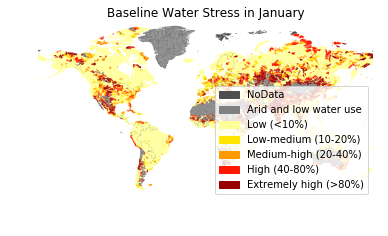

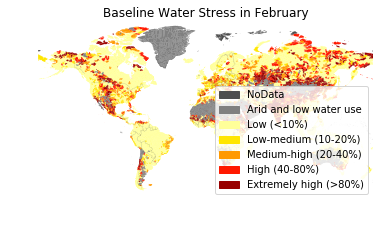

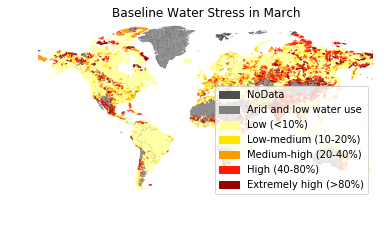

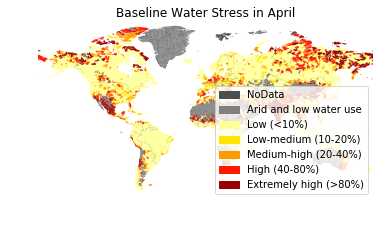

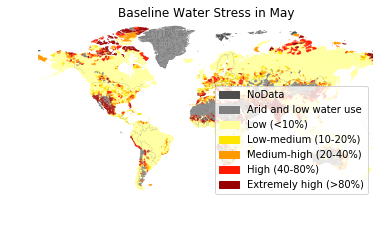

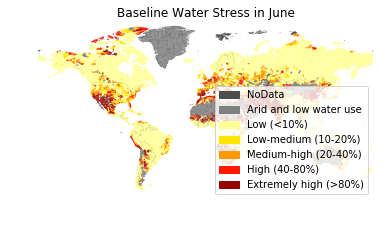

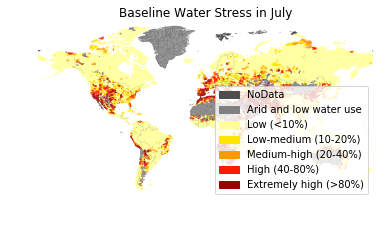

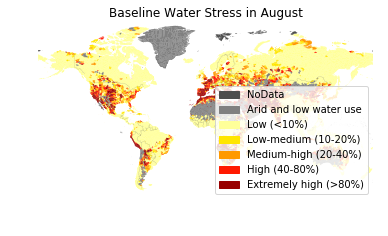

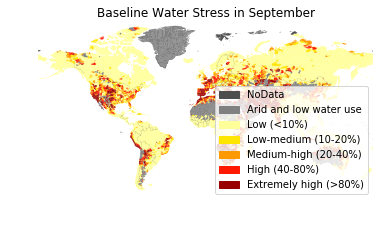

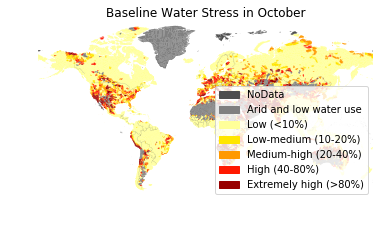

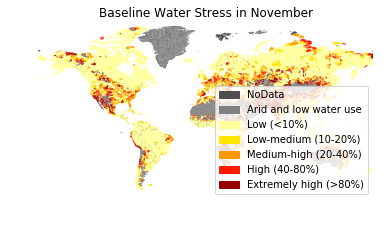

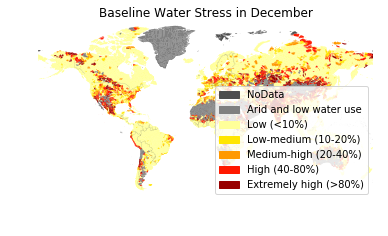

In [11]:
for month in range(1,13):
  print(month)
  
  perspective = "intl"
  scope = "global"
  countries = None
  buffer = 0

  
  all_countries, non_disputed, disputed = get_boundaries(perspective=perspective)

  disputed_projected = disputed.to_crs(miller)
  non_disputed_projected = non_disputed.to_crs(miller)
  all_countries_projected = all_countries.to_crs(miller)
  
  xmin, xmax, ymin, ymax = get_extent_miller(scope,countries,buffer)
  output_filename = "{}/bws_{:02.0f}_cat_{:02.0f}".format(output_path,month,OUTPUT_VERSION)
  
  print(output_filename,perspective, scope,xmin,xmax,ymin,ymax)
  
  bordercolor = "#4E4E4E"
  
  plot_aqueduct_bws(month,output_filename,xmin,xmax,ymin,ymax,gdf,disputed_projected,non_disputed_projected,bordercolor)

In [12]:
!gsutil -m cp -r {output_path} {GCS_OUTPUT_PATH}

Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_05_cat_04.pdf [Content-Type=application/pdf]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_11_cat_04.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_09_cat_04.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_01_cat_04.pdf [Content-Type=application/pdf]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_12_cat_04.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_08_cat_04.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_01_cat_04.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_04_cat_04.jpg [Content-Type=image/jpeg]...
Copying file://Y2019M07D29_RH_Aqueduct_Plot_Monthly_V01/output_V04/bws_05_cat_